In [1]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
import networkx as nx
import OmicsIntegrator as oi
from upsetplot import from_contents, UpSet
from scipy import stats
import pickle
import itertools
from tqdm import tqdm
import time
import random
import json

import intermingling_utils as diff

In [2]:
# Reload modules in case of modifications
reload(diff)

<module 'intermingling_utils' from '/home/braunger/masterthesis/relevant_code/Python/Intermingling_difference_maps/intermingling_utils.py'>

In [3]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
hic_dir = save_dir + 'processed_hic_data/'
las_dir = '/home/braunger/rejuvenation_project/data/processed_hic_data/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'

# 1. Binarized maps and difference matrix

In [4]:
young = pd.read_csv(hic_dir+'Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(hic_dir+'Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)

# Differences between young and old
diff_map = young + 2 * old #0: no intermingling, 1: young-specific, 2: old-specific, 3: shared intermingling
print(diff_map.shape)
diff_map.to_csv(hic_dir+'difference_maps/diff_all_gene_loci.csv')

(5399, 5399)


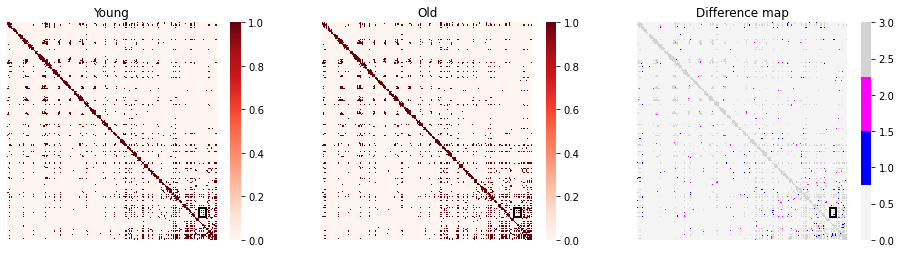

In [5]:
%matplotlib inline
diff.plot_binarized_maps(young, old, diff_map, filtering = False)
plt.savefig(fig_dir+'diff_map_all_loci', dpi = 500)

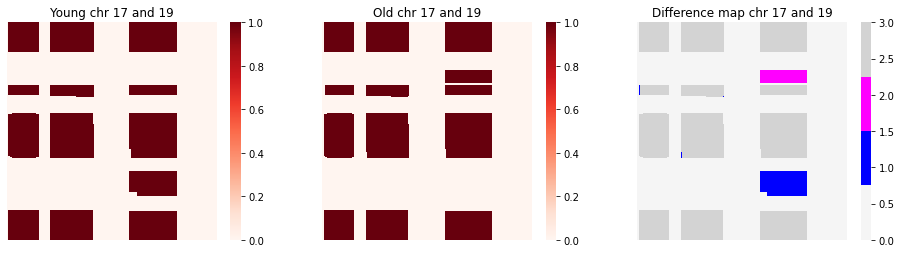

In [6]:
%matplotlib inline
diff.plot_binarized_maps_chr_pair(young, old, diff_map, chr_pair = (17, 19))
plt.savefig(fig_dir+'diff_map_chr17_19', dpi = 500)

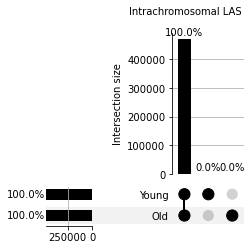

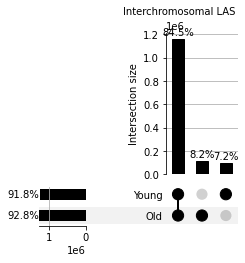

In [7]:
# How strongly do the interactions overlap
def get_intra(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] == df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

def get_inter(df):
    df['loc1'] = df.index
    df = pd.melt(df, id_vars = 'loc1', var_name = 'loc2')
    df = df[df['value'] != 0]
    df['chr1'] = df['loc1'].str.split('_').str[1]
    df['chr2'] = df['loc2'].str.split('_').str[1]
    df = df[df['chr1'] != df['chr2']]
    interactions = [df.iloc[ix, 0] + "-" + df.iloc[ix, 1] for ix in range(0, df.shape[0])]
    return interactions

# UpSet plot for intrachromosomal contacts
intersections = from_contents({'Old': get_intra(old), 
                               'Young': get_intra(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,
             sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Intrachromosomal LAS')
plt.savefig(fig_dir + 'intra_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# UpSet plot for interchromosomal contacts
intersections = from_contents({'Old': get_inter(old),
                               'Young': get_inter(young)})
upset = UpSet(intersections, subset_size='count', show_percentages = True,  
              sort_by="cardinality", sort_categories_by=None).plot()
plt.figtext(0.45, 0.95, 'Interchromosomal LAS')
plt.savefig(fig_dir + 'inter_LAS_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# 2. Number of intermingling regions per chromosome pair

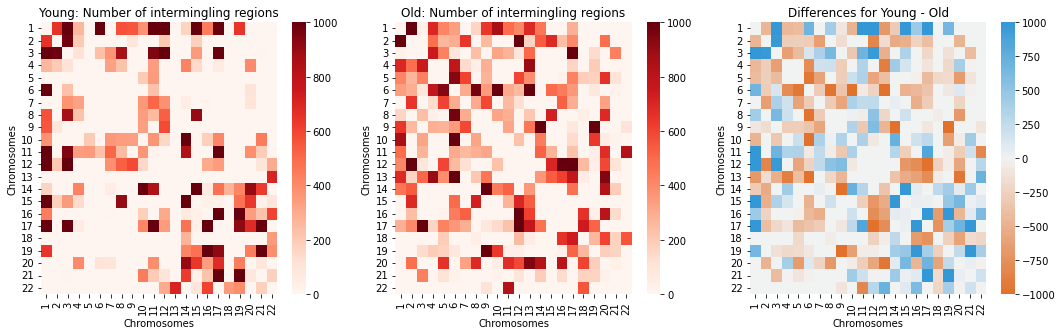

In [8]:
chr_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
fig, axs = plt.subplots(1, 3, figsize = (18, 5))
diff.plot_specific_intermingling(chr_list, diff_map, "Young", axs[0])
diff.plot_specific_intermingling(chr_list, diff_map, "Old", axs[1])
diff.plot_intermingling_diff(chr_list, diff_map, "Young", "Old", axs[2], -1000, 1000)
plt.savefig(fig_dir + 'specific_intermingling_per_chr_pair.png', dpi = 500, bbox_inches="tight")
plt.show()

In [9]:
# Total number of interchromosomal LAS submatrices
young_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R1', 20)
print('Young replicate 1: ', int(young_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R1['LAS'].sum()), ' submatrices')
young_B1R2 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R2', 20)
print('Young replicate 2: ', int(young_B1R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R2['LAS'].sum()), ' submatrices')
old_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Old_B1R1', 20)
print('Old replicate 1: ', int(old_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B1R1['LAS'].sum()), ' submatrices')
old_B2R2 = diff.LAS_statistics(chr_list, las_dir, 'Old_B2R2', 20)
print('Old replicate 2: ', int(old_B2R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B2R2['LAS'].sum()), ' submatrices')

Young replicate 1:  888654  intermingling regions  and  1162  submatrices
Young replicate 2:  936314  intermingling regions  and  1177  submatrices
Old replicate 1:  861632  intermingling regions  and  1013  submatrices
Old replicate 2:  1193155  intermingling regions  and  1325  submatrices


In [10]:
# Total number of intrachromosomal LAS submatrices
young_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R1', 'intra-5')
print('Young replicate 1: ', int(young_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R1['LAS'].sum()), ' submatrices')
young_B1R2 = diff.LAS_statistics(chr_list, las_dir, 'Young_B1R2', 'intra-5')
print('Young replicate 2: ', int(young_B1R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(young_B1R2['LAS'].sum()), ' submatrices')
old_B1R1 = diff.LAS_statistics(chr_list, las_dir, 'Old_B1R1', 'intra-5')
print('Old replicate 1: ', int(old_B1R1['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B1R1['LAS'].sum()), ' submatrices')
old_B2R2 = diff.LAS_statistics(chr_list, las_dir, 'Old_B2R2', 'intra-5')
print('Old replicate 2: ', int(old_B2R2['intermingling_regions'].sum()), ' intermingling regions', 
     ' and ', int(old_B2R2['LAS'].sum()), ' submatrices')

Young replicate 1:  1480875  intermingling regions  and  1972  submatrices
Young replicate 2:  1578772  intermingling regions  and  1984  submatrices
Old replicate 1:  1647161  intermingling regions  and  1738  submatrices
Old replicate 2:  1664599  intermingling regions  and  1694  submatrices


# 3. Difference maps
## a) Intermingling of signature DE genes in Group 1 and Group 5

(170, 7)
(158, 158)
(170, 7)


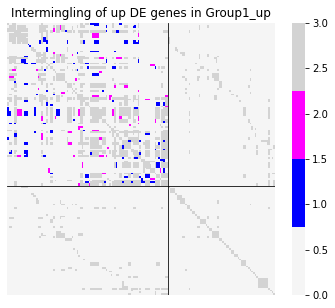

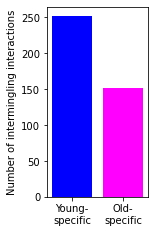

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:39:46<00:00,  5.99s/it]


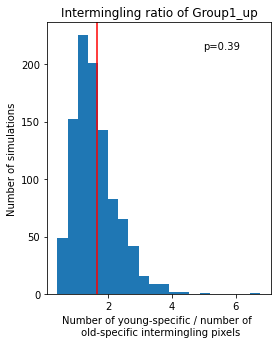

In [11]:
# Upregulated genes in group 1 
# Plot intermingling difference map    
diff.diff_map_sig(diff_map, 'Group1_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group1.png', dpi = 500, bbox_inches="tight")

# plot amount of intermingling types in the map
DE_diff_map = diff.get_diff_map_sig(diff_map, 'Group1_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group1_up.png', dpi = 500, bbox_inches="tight")
plt.show()

# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group1_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group1_up.png', dpi = 500, bbox_inches="tight")

(170, 7)
(153, 153)
(170, 7)


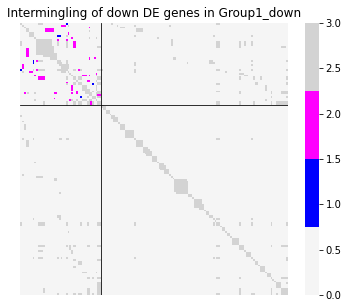

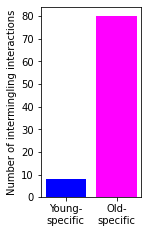

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:22:11<00:00,  4.93s/it]


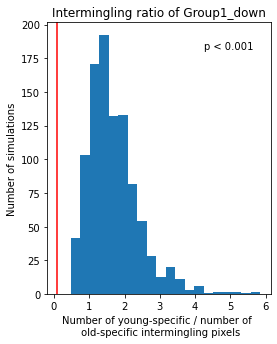

In [12]:
# Downregulated genes in group 1 
# Plot intermingling difference map    
diff.diff_map_sig(diff_map, 'Group1_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group1.png', dpi = 500, bbox_inches="tight")

# plot amount of intermingling types in the map
DE_diff_map = diff.get_diff_map_sig(diff_map, 'Group1_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group1_down.png', dpi = 500, bbox_inches="tight")
plt.show()

# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group1_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group1_down.png', dpi = 500, bbox_inches="tight")

(170, 7)
(154, 154)
(170, 7)


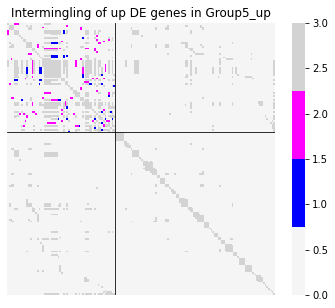

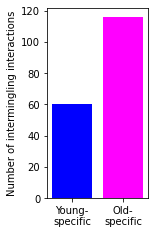

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:06:33<00:00,  3.99s/it]


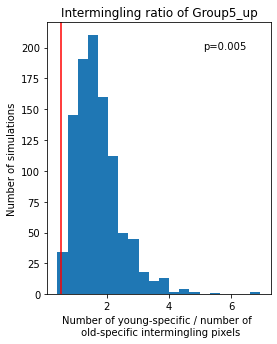

In [13]:
# Upregulated genes in group 5 
# Plot intermingling difference map    
diff.diff_map_sig(diff_map, 'Group5_up', 'up', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_up_Group5.png', dpi = 500, bbox_inches="tight")

# plot amount of intermingling types in the map
DE_diff_map = diff.get_diff_map_sig(diff_map, 'Group5_up', 'up', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group5_up.png', dpi = 500, bbox_inches="tight")
plt.show()

# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group5_up', 'up', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group5_up.png', dpi = 500, bbox_inches="tight")

(170, 7)
(163, 163)
(170, 7)


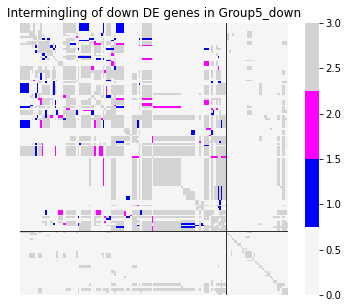

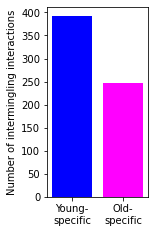

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:10:03<00:00,  4.20s/it]


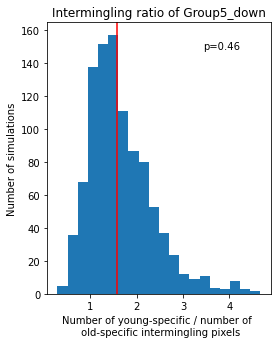

In [14]:
# Downregulated genes in group 5 
# Plot intermingling difference map    
diff.diff_map_sig(diff_map, 'Group5_down', 'down', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_down_Group5.png', dpi = 500, bbox_inches="tight")

# plot amount of intermingling types in the map
DE_diff_map = diff.get_diff_map_sig(diff_map, 'Group5_down', 'down', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
plt.figure(figsize = (1.8, 3.5))
plt.bar(['Young-\nspecific', 'Old-\nspecific'], [young_specific_im, old_specific_im], color = ['blue', 'magenta'])
plt.ylabel('Number of intermingling interactions')
plt.savefig(fig_dir + 'bars_Group5_down.png', dpi = 500, bbox_inches="tight")
plt.show()

# young / old-specific intermingling ratio
diff.quantify_im_ratio(diff_map, 'Group5_down', 'down', data_dir, save_dir, young_specific_im, old_specific_im, shared_im)
plt.savefig(fig_dir + 'im_ratio_Group5_down.png', dpi = 500, bbox_inches="tight")

## b) Intermingling of target DE genes per TF 

(66, 2)


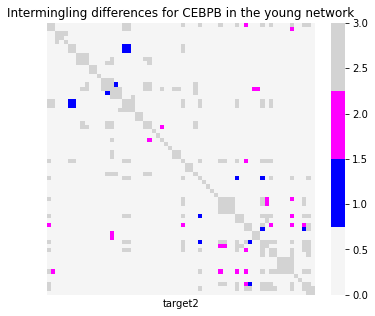

In [15]:
diff.diff_map_TF_transition(diff_map, 'CEBPB', 'fc_16-26_27-60', 'young', data_dir, save_dir)

(62, 2)


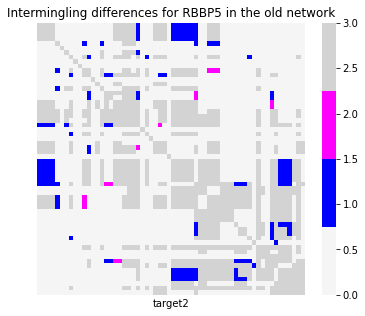

In [16]:
diff.diff_map_TF_transition(diff_map, 'RBBP5', 'fc_61-85_86-96', 'old', data_dir, save_dir)

In [17]:
# quantify amount of intermingling between the DE targets of each TF
net = 'old'
if net == "young": 
    transition = "fc_16-26_27-60"
elif net == "old": 
    transition = "fc_61-85_86-96"

# Select TFs identified in the network of interest
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')
TF_list = TF_groups.loc[TF_groups['net'] == net + '_net', 'TF']
# Load DE genes for the selected transition
DE_diff_map = diff.get_diff_map_DE(diff_map, transition, data_dir, save_dir)

spec_intermingling = pd.DataFrame({'TF': [], 'spec_intermingling': [], 'shared_intermingling': []})
for TF in TF_list:
    
    # load DE targets of selected TF
    TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
    TF_targets = TF_targets[TF_targets['TF'] == TF]
    TF_targets = TF_targets[TF_targets['target'].isin(DE_diff_map.columns)]
    
    # calculate percentages of cell-state specific and shared intermingling
    TF_diff_long = DE_diff_map.loc[TF_targets['target'], TF_targets['target']]
    TF_diff_long['loc1'] = TF_diff_long.index
    TF_diff_long = TF_diff_long.melt(id_vars = 'loc1', var_name = 'loc2')
    count_spec_im = TF_diff_long['value'].isin([1,2]).sum() / TF_diff_long.shape[0]
    count_shared_im = TF_diff_long['value'].isin([3]).sum() / TF_diff_long.shape[0]
    spec_intermingling = pd.concat([spec_intermingling, 
                                   pd.DataFrame({'TF': [TF], 
                                                'spec_intermingling': count_spec_im, 
                                                'shared_intermingling': count_shared_im})], 
                                   ignore_index = True)
     
spec_intermingling.to_csv(hic_dir + 'spec_intermingling_' + net + '.csv', index = False)    
print(spec_intermingling.head())

(162, 5)


/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


      TF  spec_intermingling  shared_intermingling
0   TAF3            0.048414              0.270032
1    MNT            0.022676              0.269841
2   ARNT            0.043995              0.309750
3   SIX5            0.037190              0.305785
4  CEBPD            0.015123              0.240076


## c) Intermingling of all upregulated DE target genes in S1 and downregulated DE target genes in S3

(131, 5)
(131, 5)
(124, 124)


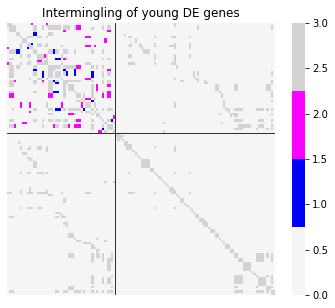

In [18]:
# Upregulated targets in S1
DE_diff_map = diff.get_diff_map_DE(diff_map, 'fc_16-26_27-60', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)
    
# Plot intermingling difference map    
diff.diff_map_DE(diff_map, 'fc_16-26_27-60', 'young', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_young_DE.png', dpi = 500, bbox_inches="tight")

(162, 5)
(162, 5)
(157, 157)


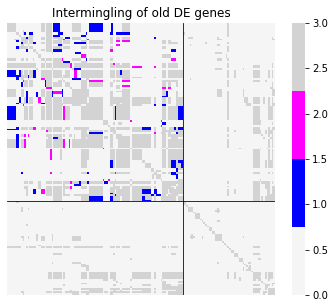

In [19]:
# Downregulated targets in S3
DE_diff_map = diff.get_diff_map_DE(diff_map, 'fc_61-85_86-96', data_dir, save_dir)
young_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 1)
old_specific_im = np.count_nonzero(DE_diff_map.to_numpy() == 2)
shared_im = np.count_nonzero(DE_diff_map.to_numpy() == 3)

# Plot intermingling difference map
diff.diff_map_DE(diff_map, 'fc_61-85_86-96', 'old', data_dir, save_dir)
plt.savefig(fig_dir + 'diff_map_old_DE.png', dpi = 500, bbox_inches="tight")

# 4. Number of Bridge TFs targeting each gene

(131, 5)


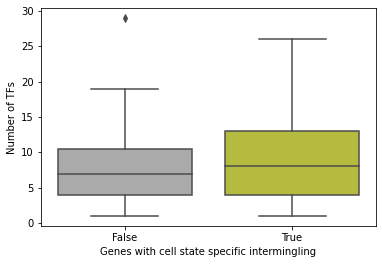

In [20]:
# Steiner network S1
DE_diff_map_young = diff.get_diff_map_DE(diff_map, 'fc_16-26_27-60', data_dir, save_dir)
intermingling_genes = DE_diff_map_young.columns[(DE_diff_map_young.isin([1, 2])).any(axis=1)].tolist()
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == 'fc_16-26_27-60']
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['young_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'False'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'True'
target_counts.to_csv(save_dir+'DE_genes/n_TFs_per_young_DE_gene.csv', index = False)

plt.figure()
my_pal = {"False": "#aaaaaa", "True": "#c6d02a"}
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs', palette = my_pal) 
plt.ylabel('Number of TFs')
plt.xlabel('Genes with cell state specific intermingling')
plt.savefig(fig_dir + 'n_TFs_young_DE.png')
plt.show()

(162, 5)


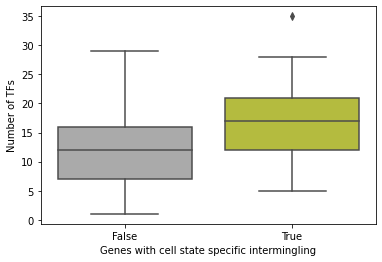

In [21]:
# Steiner network S3
DE_diff_map_old = diff.get_diff_map_DE(diff_map, 'fc_61-85_86-96', data_dir, save_dir)
intermingling_genes = DE_diff_map_old.columns[(DE_diff_map_old.isin([1, 2])).any(axis=1)].tolist()
TF_groups = pd.read_csv(save_dir+'pcst/incl_TFs_design2.csv')

TF_targets = pd.read_csv(save_dir+'TF_targets/TF_targets_anno.csv')
DE_genes = pd.read_csv(save_dir + 'DE_genes/DE_updown.csv')
DE_genes = DE_genes[DE_genes['transition'] == 'fc_61-85_86-96']
TF_targets = TF_targets[TF_targets['target'].isin(DE_genes['gene'])]
TF_targets = TF_targets[TF_targets['TF'].isin(TF_groups.loc[TF_groups['net'].isin(['old_net', 'shared']), 'TF'])]

target_counts = TF_targets.groupby('target')['target'].count()
target_counts = pd.DataFrame({'target': target_counts.index, 
                              'n_TFs': target_counts.values, 
                              'intermingling': 'False'})
target_counts.loc[target_counts['target'].isin(intermingling_genes), 'intermingling'] = 'True'
target_counts.to_csv(save_dir+'DE_genes/n_TFs_per_old_DE_gene.csv', index = False)

plt.figure()
sns.boxplot(data=target_counts, x='intermingling', y='n_TFs', palette = my_pal) 
plt.ylabel('Number of TFs')
plt.xlabel('Genes with cell state specific intermingling')
plt.savefig(fig_dir + 'n_TFs_old_DE.png')
plt.show()

# 5. Intermingling networks for selected bridge TFs
The following function creates a json file that contains all the network information. 
To obtain the network, please run 'python create_intermingling_networks.py' which uses dash cytoscape to create an interactive network in the browser in which the nodes can be dragged around.

In [22]:
# Intermingling network for all DE targets of a bridge TF in a given network
TF = 'RBBP5'
network = 'S3' 
cy = diff.create_interactive_net_json(diff_map, TF, network, data_dir, save_dir)
with open(save_dir+"cytoscape/cytoscape_"+TF+".json", "w") as outfile:
    json.dump(cy, outfile)

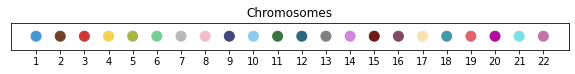

In [23]:
# define colors based on the chromosome
chr_palette = pd.DataFrame({'chromosome': [str(i) for i in range(1, 23)],
                           'color': ["#4397D4", "#743F27", "#CD3836", "#F7D24A", "#A7B547", "#76CE97", 
                                     "#B9B9B9", "#F0BFC9", "#434679", "#8CCBEF", "#3C723E", 
                                     "#2C677C", "#7E8180", "#D285DE", "#6F1C16", "#814965", "#FAE1AE", 
                                     "#4299A9", "#E1646B", "#B10DA1", "#7DE2E7", "#C075A6"] })

plt.figure(figsize = (10, 0.5))
plt.scatter(x =chr_palette['chromosome'], y =  [2] * chr_palette['chromosome'].shape[0], 
            c = chr_palette['color'], s = 100)
plt.yticks([])
plt.title('Chromosomes')
plt.savefig(fig_dir + 'chr_colors_horizontal.png', dpi = 500, bbox_inches="tight")
plt.show()

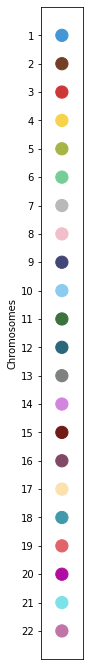

In [24]:
plt.figure(figsize = (0.75, 12))
plt.scatter(x = [2] * chr_palette['chromosome'].shape[0], y = chr_palette['chromosome'], 
            c = chr_palette['color'], s = 150)
plt.xticks([])
plt.ylim(22, -1)
plt.ylabel('Chromosomes')
plt.savefig(fig_dir + 'chr_colors.png', dpi = 500, bbox_inches="tight")
plt.show()